In [26]:
%rm -rf ANN_for_MPC_pretraining
! git clone https://github.com/panos108/ANN_for_MPC_pretraining.git
! pip install casadi
import casadi

Cloning into 'ANN_for_MPC_pretraining'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 78 (delta 41), reused 54 (delta 23), pack-reused 0
Unpacking objects: 100% (78/78), done.


Define two Case studies

In [27]:
# GP NMPC problem setup
import numpy as np
from casadi import *


class Bio_reactor:

    def specifications(self):
        ''' Specify Problem parameters '''
        tf              = 240.      # final time
        nk              = 12        # sampling points
        dt              = tf/nk
        x0              = np.array([1.,150.,0.])
        Lsolver         = 'mumps'  #'ma97'  # Linear solver
        c_code          = False    # c_code
        shrinking_horizon = True

        return dt, x0, Lsolver, c_code, shrinking_horizon

    def DAE_system(self):
        # Define vectors with names of states
        states     = ['x','n','q']
        nd         = len(states)
        xd         = SX.sym('xd',nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = []
        na         = len(algebraics)
        xa         = SX.sym('xa',na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        set_points = []
        n_ref      = len(set_points)
        x_ref      = SX.sym('x_ref',n_ref)
        for i in range(n_ref):
            globals()[set_points[i]] = x_ref[i]



        # Define vectors with banes of input variables
        inputs     = ['L','Fn']
        nu         = len(inputs)
        u          = SX.sym("u",nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        # Define model parameter names and values
        modpar    = ['u_m', 'k_s', 'k_i', 'K_N', 'u_d', 'Y_nx', 'k_m', 'k_sq',
        'k_iq', 'k_d', 'K_Np']
        modparval = [0.0923*0.62, 178.85, 447.12, 393.10, 0.001, 504.49,
        2.544*0.62*1e-4, 23.51, 800.0, 0.281, 16.89]

        nmp       = len(modpar)
        uncertainty = []#SX.sym('uncp', nmp)
        for i in range(nmp):
            globals()[modpar[i]] = SX(modparval[i])# + uncertainty[i])

        # Additive measurement noise
    #    Sigma_v  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Additive disturbance noise
    #    Sigma_w  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Initial additive disturbance noise
    #    Sigma_w0 = [1.,150.**2,0.]*diag(np.ones(nd))*1e-3
        # Declare ODE equations (use notation as defined above)

        dx   = u_m * L/(L+k_s+L**2./k_i) * x * n/(n+K_N) - u_d*x
        dn   = - Y_nx*u_m* L/(L+k_s+L**2./k_i) * x * n/(n+K_N)+ Fn
        dq   = (k_m * L/(L+k_sq+L**2./k_iq) * x - k_d * q/(n+K_Np))# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

              # * (tanh(1000*(500. - n))+1)/2 * (tanh(1000*(x - 10.000))+1)/2# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

        ODEeq =  [dx, dn, dq]

        # Declare algebraic equations
        Aeq = []

        # Define objective to be minimized
        t     = SX.sym('t')
        Obj_M = Function('mayer', [xd, x_ref, u], [-q])  # Mayer term
        Obj_L = Function('lagrange', [xd, x_ref, u], [0.])  # Lagrange term
        Obj_D = Function('Discrete', [xd, x_ref, u], [0.])  # Lagrange term

        R           = np.diagflat([3.125e-8, 3.125e-006])                         # Weighting of control penality

        # Define control bounds
        u_min = np.array([120., 0.])
        u_max = np.array([400., 40.])
        x_min = np.array([0.]*nd)
        x_max = np.array([np.inf]*nd)
        # Define constraint functions g(x) <= 0
        gequation = vertcat(n - 800., q - 0.011 * x)
        ng = SX.size(gequation)[0]
        gfcn = Function('gfcn', [xd, xa, u], [gequation])

        return xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states,\
               algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R


    def integrator_model(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
         inputs: NaN
         outputs: F: Function([x, u, dt]--> [xf, obj])
        """

        xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states, \
        algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R = self.DAE_system()

        dae = {'x': vertcat(xd), 'z': vertcat(xa), 'p': vertcat(u, uncertainty),
               'ode': vertcat(*ODEeq), 'alg': vertcat(*Aeq)}
        opts = {'tf': 240/12}  # interval length
        F = integrator('F', 'idas', dae, opts)

        return F


class Bio_reactor_unc:

    def specifications(self):
        ''' Specify Problem parameters '''
        tf              = 240.      # final time
        nk              = 12        # sampling points
        dt              = tf/nk
        x0              = np.array([1.,150.,0.])
        Lsolver         = 'mumps'  #'ma97'  # Linear solver
        c_code          = False    # c_code
        shrinking_horizon = True

        return dt, x0, Lsolver, c_code, shrinking_horizon

    def DAE_system(self):
        # Define vectors with names of states
        states     = ['x','n','q']
        nd         = len(states)
        xd         = SX.sym('xd',nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = []
        na         = len(algebraics)
        xa         = SX.sym('xa',na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        set_points = []
        n_ref      = len(set_points)
        x_ref      = SX.sym('x_ref',n_ref)
        for i in range(n_ref):
            globals()[set_points[i]] = x_ref[i]



        # Define vectors with banes of input variables
        inputs     = ['L','Fn']
        nu         = len(inputs)
        u          = SX.sym("u",nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        # Define model parameter names and values
        modpar    = ['u_m', 'k_s', 'k_i', 'K_N', 'u_d', 'Y_nx', 'k_m', 'k_sq',
        'k_iq', 'k_d', 'K_Np']
        modparval = [0.0923*0.62, 178.85, 447.12, 393.10, 0.001, 504.49,
        2.544*0.62*1e-4, 23.51, 800.0, 0.281, 16.89]

        nmp       = len(modpar)
        uncertainty = SX.sym('uncp', nmp)
        for i in range(nmp):
            globals()[modpar[i]] = SX(modparval[i] + uncertainty[i])

        # Additive measurement noise
    #    Sigma_v  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Additive disturbance noise
    #    Sigma_w  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Initial additive disturbance noise
    #    Sigma_w0 = [1.,150.**2,0.]*diag(np.ones(nd))*1e-3
        # Declare ODE equations (use notation as defined above)

        dx   = u_m * L/(L+k_s+L**2./k_i) * x * n/(n+K_N) - u_d*x
        dn   = - Y_nx*u_m* L/(L+k_s+L**2./k_i) * x * n/(n+K_N)+ Fn
        dq   = (k_m * L/(L+k_sq+L**2./k_iq) * x - k_d * q/(n+K_Np))# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

              # * (tanh(1000*(500. - n))+1)/2 * (tanh(1000*(x - 10.000))+1)/2# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

        ODEeq =  [dx, dn, dq]

        # Declare algebraic equations
        Aeq = []

        # Define objective to be minimized
        t     = SX.sym('t')
        Obj_M = Function('mayer', [xd, x_ref, u], [-q])  # Mayer term
        Obj_L = Function('lagrange', [xd, x_ref, u], [0.])  # Lagrange term
        Obj_D = Function('Discrete', [xd, x_ref, u], [0.])  # Lagrange term

        R           = np.diagflat([3.125e-8, 3.125e-006])                         # Weighting of control penality

        # Define control bounds
        u_min = np.array([120., 0.])
        u_max = np.array([400., 40.])
        x_min = np.array([0.]*nd)
        x_max = np.array([np.inf]*nd)
        # Define constraint functions g(x) <= 0
        gequation = vertcat(n - 800., q - 0.011 * x)
        ng = SX.size(gequation)[0]
        gfcn = Function('gfcn', [xd, xa, u], [gequation])

        return xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states,\
               algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R


    def integrator_model(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
         inputs: NaN
         outputs: F: Function([x, u, dt]--> [xf, obj])
        """

        xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states, \
        algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R = self.DAE_system()

        dae = {'x': vertcat(xd), 'z': vertcat(xa), 'p': vertcat(u, uncertainty),
               'ode': vertcat(*ODEeq), 'alg': vertcat(*Aeq)}
        opts = {'tf': 240/12}  # interval length
        F = integrator('F', 'idas', dae, opts)

        return F






class simple_CSTR:

    def specifications(self):
        ''' Specify Problem parameters '''
        dt                = 0.01      # final time
        x0                = np.array([0.])
        Lsolver           = 'mumps'  #'ma97'  # Linear solver
        c_code            = False    # c_code
        shrinking_horizon = False
        return dt, x0, Lsolver, c_code, shrinking_horizon

    def DAE_system(self):
        # Define vectors with names of states
        states     = ['x']
        nd         = len(states)
        xd         = SX.sym('xd',nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = []
        na         = len(algebraics)
        xa         = SX.sym('xa',na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        set_points = ['x_ref']
        n_ref      = len(set_points)
        x_ref      = SX.sym('x_ref',n_ref)
        for i in range(n_ref):
            globals()[set_points[i]] = x_ref[i]

        # Define vectors with banes of input variables
        inputs     = ['u']
        nu         = len(inputs)
        u          = SX.sym("u",nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        # Define model parameter names and values
        modpar    = ['u_scale', 'V', 'k', 'C0']
        modparval = [3000., 5000., 2., 1.]

        nmp       = len(modpar)
        uncertainty = []#SX.sym('uncp', nmp)
        for i in range(nmp):
            globals()[modpar[i]] = SX(modparval[i])# + uncertainty[i])

        dx   = u_scale * u / V * (C0 -x) - k * x **3

        ODEeq =  [dx]

        # Declare algebraic equations
        Aeq = []

        # Define objective to be minimized
        t     = SX.sym('t')
        Obj_M = Function('mayer', [xd, x_ref, u], [0.])  # Mayer term
        Obj_L = Function('lagrange', [xd, x_ref, u], [(x-x_ref)**2])  # Lagrange term
        Obj_D = Function('Discrete', [xd, x_ref, u], [0.])  # Lagrange term

        R           = np.eye(nu)#np.diagflat([3.125e-8, 3.125e-006])                         # Weighting of control penality

        # Define control bounds
        u_min = np.array([0.])
        u_max = np.array([1.])
        x_min = np.array([0.]*nd)
        x_max = np.array([np.inf]*nd)
        # Define constraint functions g(x) <= 0
        gequation = vertcat(x - 1.)
        ng = SX.size(gequation)[0]
        gfcn = Function('gfcn', [xd, x_ref, u], [gequation])

        return xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states,\
               algebraics, inputs, nd, na, nu,n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R



    def integrator_model(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
         inputs: NaN
         outputs: F: Function([x, u, dt]--> [xf, obj])
        """
        dt, x0, Lsolver, c_code, specifications = self.specifications()

        xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states, \
        algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R = self.DAE_system()

        dae = {'x': vertcat(xd), 'z': vertcat(xa), 'p': vertcat(u, uncertainty),
               'ode': vertcat(*ODEeq), 'alg': vertcat(*Aeq)}
        opts = {'tf': dt}  # interval length
        F = integrator('F', 'idas', dae, opts)

        return F


Bioreactor with shrinking Horizon

In [8]:
import numpy as np
variance = np.array([0, 17.885, 44.712, 39.310, 0, 0, # Define variances
        0, 0, 0, 0, 0])
Cov = np.diag(variance) 
Cov = np.zeros((11,11))

In [18]:
from casadi import *
import numpy as np
from ANN_for_MPC_pretraining.utilities import MPC
import matplotlib.pyplot as plt

System     = Bio_reactor
System_unc = Bio_reactor_unc
N =12 # This is the total steps
#Initialize system
Sys = System_unc()
dt, x0, _, _, _ = Sys.specifications()
F = Sys.integrator_model()
# Construct MPC
MPC_ = MPC(System, horizon=N, penalize_u=False) 
# Define system

# Initialize Matrices
his_x = np.zeros([1000, len(x0)])
his_u = np.zeros([1000, 2])
t     = 0.
u_apply = np.array([0.])

for k in range(10):
    dp = np.random.multivariate_normal([0]*11, Cov)
    for i in range(12):
        his_x[i] = x0
        u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, t=t) # Deterministic Model

        u_apply  = np.array(u_opt)[:,0]
        his_u[i] = u_apply
        x1 = F(x0=x0, p=vertcat(u_apply, dp))           # Real System
        x0 = np.array(x1['xf']).reshape((-1,))
        t += dt
plt.plot(his_x[:N])


ValueError: ignored

In [28]:
## TEST ##
from casadi import *
import numpy as np
from ANN_for_MPC_pretraining.utilities import MPC
import matplotlib.pyplot as plt

System     = Bio_reactor
System_unc = Bio_reactor_unc
N =12 # This is the total steps
#Initialize system
Sys = System()
dt, x0, _, _, _ = Sys.specifications()
F = Sys.integrator_model()
# Construct MPC
MPC_ = MPC(System, horizon=N, penalize_u=False) 
# Define system

# Initialize Matrices
his_x = np.zeros([1000, len(x0)])
his_u = np.zeros([1000, 2])
t     = 0.
u_apply = np.array([0.])

for k in range(10):
    dp = np.random.multivariate_normal([0]*11, Cov)
    for i in range(12):
        his_x[i] = x0
        u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, t=t) # Deterministic Model

        u_apply  = np.array(u_opt)[:,0]
        his_u[i] = u_apply
        x1 = F(x0=x0, p=u_apply)           # Real System
        x0 = np.array(x1['xf']).reshape((-1,))
        t += dt
plt.plot(his_x[:N])


ValueError: ignored

Simple CSTR with penalizing $\Delta u$

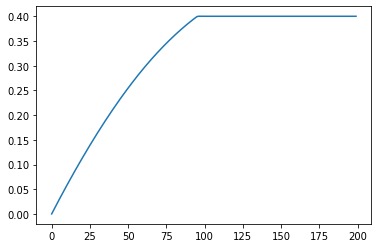

In [24]:
from casadi import *
import numpy as np
from ANN_for_MPC_pretraining.utilities import MPC
import matplotlib.pyplot as plt
System = simple_CSTR
N =10 # This is the horizon


#Initialize system
Sys = System()
dt, x0, _, _, _ = Sys.specifications()
F = Sys.integrator_model()
his_x = np.zeros([1000, len(x0)])
his_u= np.zeros([1000, 1])
t    = 0.
u_apply = np.array([0.])

# Construct MPC
MPC_ = MPC(System, horizon=N, penalize_u=False) 

Sys = System()
dt, x0, _, _, _ = Sys.specifications()
F = Sys.integrator_model()
his_x = np.zeros([1000, len(x0)])
his_u= np.zeros([1000, 1])
t    = 0.
u_apply = np.array([0.])

for i in range(200):
    his_x[i] = x0
    u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, ref = 0.4, t=t)

    u_apply  = np.array(u_opt)[:,0]
    his_u[i] = u_apply
    x1 = F(x0=x0, p=u_apply)
    x0 = np.array(x1['xf']).reshape((-1,))
    t += dt
plt.plot(his_x[:200])

Simple CSTR with penalizing $\Delta u$

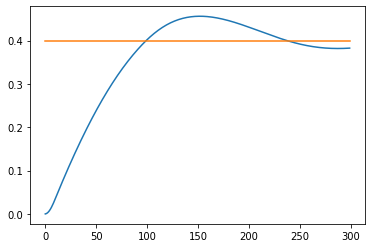

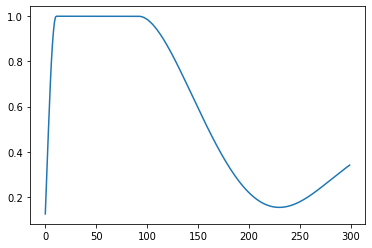

In [ ]:
from casadi import *
import numpy as np
from ANN_for_MPC_pretraining.utilities import MPC
import matplotlib.pyplot as plt
System = simple_CSTR
N =10 # This is the horizon

#Initialize system
Sys = System()
dt, x0, _, _, _ = Sys.specifications()
F = Sys.integrator_model()
his_x = np.zeros([1000, len(x0)])
his_u= np.zeros([1000, 1])
t    = 0.
u_apply = np.array([0.])
# Construct MPC
MPC_ = MPC(System, horizon=N, penalize_u=True) 



for i in range(300):
    his_x[i] = x0
    u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, u=u_apply, ref = 0.4, t=t)

    u_apply  = np.array(u_opt)[:,0]
    his_u[i] = u_apply
    x1 = F(x0=x0, p=u_apply)
    x0 = np.array(x1['xf']).reshape((-1,))
    t += dt
plt.plot(his_x[:300])
plt.plot([0.4]*300)

fig1, ax1 = plt.subplots()

plt.plot(his_u[:300])